## Project Setup:

In [1422]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import os


# Read the CSV file OnlineRetail.csv
online_retail_raw_df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

------------------------------------------------------------------------------


## Dataset Exploration, Cleaning and Enhancement:


### Dataset Dimension & Preview

In [1423]:
# Dataset dimension
print(f"Dataset Shape: {online_retail_raw_df.shape[0]} Rows, {online_retail_raw_df.shape[1]} Columns\n")


# Viewing the first and last 3 rows of data
pd.set_option('display.width', 1000);
print(pd.concat([online_retail_raw_df.head(3), online_retail_raw_df.tail(3)]))


Dataset Shape: 541909 Rows, 8 Columns

       InvoiceNo StockCode                         Description  Quantity      InvoiceDate  UnitPrice  CustomerID         Country
0         536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   12/1/2010 8:26       2.55     17850.0  United Kingdom
1         536365     71053                 WHITE METAL LANTERN         6   12/1/2010 8:26       3.39     17850.0  United Kingdom
2         536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   12/1/2010 8:26       2.75     17850.0  United Kingdom
541906    581587     23254       CHILDRENS CUTLERY DOLLY GIRL          4  12/9/2011 12:50       4.15     12680.0          France
541907    581587     23255     CHILDRENS CUTLERY CIRCUS PARADE         4  12/9/2011 12:50       4.15     12680.0          France
541908    581587     22138       BAKING SET 9 PIECE RETROSPOT          3  12/9/2011 12:50       4.95     12680.0          France


Observations:
* The dataset contains 8 columns and 541,909 records.
* There are 3 identifier columns: InvoiceNo, StockCode, CustomerID.

### Datatypes, Unique & Missing Values

In [1424]:
#Function to summarize the dataset
def summarize_df(df):
    summary = pd.DataFrame({
        'Non-NullCount': df.notnull().sum(),
        'NullCount': df.isnull().sum(),
        'Null(%)': ((df.isnull().sum() / len(df)) * 100).round(2),
        'UniqueValues': df.nunique(),
        'DataType': df.dtypes
    })
    return summary
print(summarize_df(online_retail_raw_df))

             Non-NullCount  NullCount  Null(%)  UniqueValues DataType
InvoiceNo           541909          0     0.00         25900   object
StockCode           541909          0     0.00          4070   object
Description         540455       1454     0.27          4223   object
Quantity            541909          0     0.00           722    int64
InvoiceDate         541909          0     0.00         23260   object
UnitPrice           541909          0     0.00          1630  float64
CustomerID          406829     135080    24.93          4372  float64
Country             541909          0     0.00            38   object


Observations:
* The dataset contains 3 datatypes
  * Object/String: *InvoiceNo, StockCode, Description, InvoiceDate, Country*
  * Float:  *UnitPrice, CustomerID*
  * Integer: *Quantity*
* Only *Description* and *CustomerID* columns have missing values 
  * *Description* is missing in 1,454 records (0.27%)
  * *CustomerID* is missing in 135,080 records (24.93%)
* *CustomerID* is a float type, which is not expected for an identifier. This will be converted to object type later after checking for invalid values.
* *InvoiceDate* is in string format, needs to be converted to datetime. 
* Unique values in *StockCode* are lower than unique values in *Description* columns. This means that some StockCode(s) may have multiple descriptions.

In [1425]:
# Print statistical summary of the dataframe
print(online_retail_raw_df.describe(include='all'))


       InvoiceNo StockCode                         Description       Quantity       InvoiceDate      UnitPrice     CustomerID         Country
count     541909    541909                              540455  541909.000000            541909  541909.000000  406829.000000          541909
unique     25900      4070                                4223            NaN             23260            NaN            NaN              38
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN  10/31/2011 14:41            NaN            NaN  United Kingdom
freq        1114      2313                                2369            NaN              1114            NaN            NaN          495478
mean         NaN       NaN                                 NaN       9.552250               NaN       4.611114   15287.690570             NaN
std          NaN       NaN                                 NaN     218.081158               NaN      96.759853    1713.600303             NaN
min   

### Duplicate Records

In [1352]:
print(f"Number of duplicate records: {(duplicate_count := online_retail_raw_df.duplicated().sum())}\nPercentage of duplicate records: {(duplicate_count / len(online_retail_raw_df)) * 100:.2f}%")

Number of duplicate records: 5268
Percentage of duplicate records: 0.97%


Observations:
* There are 5,268 duplicate records in the dataset.
* The percentage of duplicate records is 0.97%, which is relatively low.
* These duplicates are likely due to multiple entries of the same transaction. Can be dropped.


Dropping Duplicates:

In [1353]:
print(f"Number of records before dropping duplicates: {len(online_retail_raw_df)}")

# Drop duplicate records
online_retail_raw_df.drop_duplicates(inplace=True)

print(f"Number of records after dropping duplicates: {len(online_retail_raw_df)}")

Number of records before dropping duplicates: 541909
Number of records after dropping duplicates: 536641


### Column level investigation

#### <u>CustomerID</u>

##### Conversion of CustomerID Datatype:


In [1354]:
# Checking for invalid CustomerID values before conversion
print(f"Number of records with CustomerID <= 0: {len(online_retail_raw_df[online_retail_raw_df['CustomerID'] <= 0])}")

# Check if there're any digits after the decimal point
customer_id_with_valid_decimals = online_retail_raw_df['CustomerID'].astype(str).str.contains('\.[1-9]')
print(f"CustomerID counts with digits after decimal point: {customer_id_with_valid_decimals.sum()}")

print(f"Number of null CustomerID values: {online_retail_raw_df['CustomerID'].isnull().sum()}")

Number of records with CustomerID <= 0: 0
CustomerID counts with digits after decimal point: 0
Number of null CustomerID values: 135037


In [1355]:
# Convert CustomerID to object type
online_retail_raw_df['CustomerID'] = online_retail_raw_df['CustomerID'].astype(object)

# Remove the last two characters for all CustomerID with non-null values
online_retail_raw_df.loc[online_retail_raw_df['CustomerID'].notnull(), 'CustomerID'] = online_retail_raw_df.loc[online_retail_raw_df['CustomerID'].notnull(), 'CustomerID'].astype(str).str[:-2]

print("CustomerIDs after removing decimal point and zero:\n",online_retail_raw_df['CustomerID'].sample(5))
print(f"Number of null CustomerID values: {online_retail_raw_df['CustomerID'].isnull().sum()}")

CustomerIDs after removing decimal point and zero:
 70049     18077
343783    16350
144390    15493
400233      NaN
95272     17811
Name: CustomerID, dtype: object
Number of null CustomerID values: 135037


##### Attempt to impute missing CustomerID values using InvoiceNo:


A unique InvoiceNo should belong to a unique CustomerID. Check if this is true for the dataset.

In [1356]:
# Group by InvoiceNo and count unique CustomerIDs
invoice_customer_counts = online_retail_raw_df.groupby('InvoiceNo')['CustomerID'].nunique()

print(f"Number of unique InvoiceNo with more than one CustomerID: {(invoice_customer_counts > 1).sum()}")

Number of unique InvoiceNo with more than one CustomerID: 0


Checking if the InoivceNo of the missing CustomerID records have any non-null CustomerID values that can be used to impute the missing values.

In [1357]:
# Select all unique InvoiceNo for records with Null CustomerID
null_customer_invoiceno = online_retail_raw_df[online_retail_raw_df['CustomerID'].isnull()]['InvoiceNo'].unique()

print(f"Number of unique InvoiceNo with Null CustomerID: {len(null_customer_invoiceno)}")

# Count the number of unique InvoiceNo that has at least one non-null CustomerID record
invoices_with_non_null_customer = online_retail_raw_df[(online_retail_raw_df['InvoiceNo'].isin(null_customer_invoiceno)) & (online_retail_raw_df['CustomerID'].notnull())]['InvoiceNo'].nunique()

print(f"Number of unique InvoiceNo with at least one non-null CustomerID: {invoices_with_non_null_customer}")


Number of unique InvoiceNo with Null CustomerID: 3710
Number of unique InvoiceNo with at least one non-null CustomerID: 0


#### <u>Quantity</u>

##### Statistical Summary of Quantity:

In [1358]:
print(online_retail_raw_df['Quantity'].describe())

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64


##### Outliers Check:

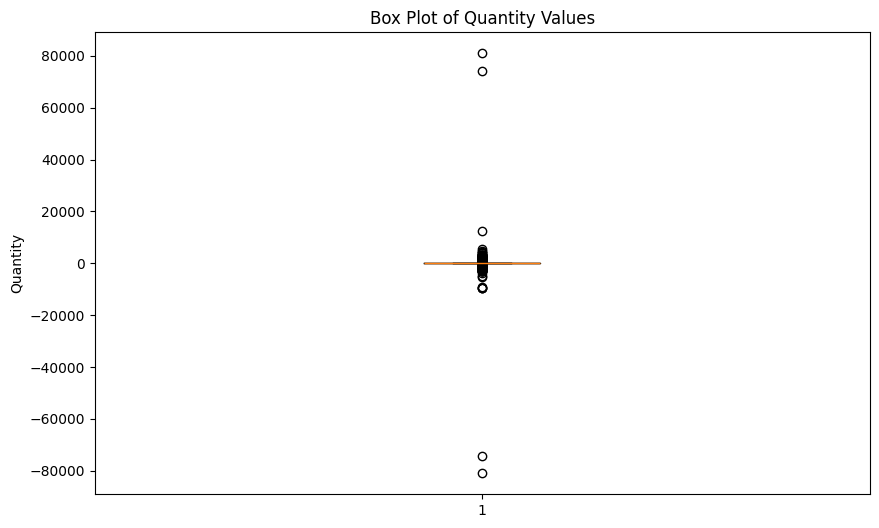

In [1359]:
# Visualize the distribution of Quantity with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(online_retail_raw_df['Quantity'])
plt.title('Box Plot of Quantity Values')
plt.ylabel('Quantity')
plt.show()

Investigating the outliers

In [1360]:
# Print records with Quantity more than 20000 or less than -20000
extreme_quantities = online_retail_raw_df[(online_retail_raw_df['Quantity'] > 20000) | (online_retail_raw_df['Quantity'] < -20000)]
print("Records with extreme Quantities (>20000 or <-20000):")
print(extreme_quantities)
print(f"\nNumber of records with extreme Quantities: {len(extreme_quantities)}")


Records with extreme Quantities (>20000 or <-20000):
       InvoiceNo StockCode                     Description  Quantity      InvoiceDate  UnitPrice CustomerID         Country
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215  1/18/2011 10:01       1.04      12346  United Kingdom
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215  1/18/2011 10:17       1.04      12346  United Kingdom
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   12/9/2011 9:15       2.08      16446  United Kingdom
540422   C581484     23843     PAPER CRAFT , LITTLE BIRDIE    -80995   12/9/2011 9:27       2.08      16446  United Kingdom

Number of records with extreme Quantities: 4


These extreme values are likely due to data entry errors as they have been cancelled. Therefore, we will drop them.

In [1361]:
records_before_outlier_removal = len(online_retail_raw_df)

# Drop records with extreme Quantity values 
online_retail_raw_df = online_retail_raw_df[(online_retail_raw_df['Quantity'] >= -40000) & (online_retail_raw_df['Quantity'] <= 40000)]

print(f"Records before outlier removal: {records_before_outlier_removal}\nRecords after outlier removal: {len(online_retail_raw_df)}\nRecords dropped: {records_before_outlier_removal - len(online_retail_raw_df)}")


Records before outlier removal: 536641
Records after outlier removal: 536637
Records dropped: 4


##### Problematic quantity values (Quantity <= 0):

From the previous boxplot and statistics, we can see that there are some negative quantity values. Let's check if these are adjustment/cancelled records.

In [1362]:
# Problematic quantity values count & percentage
print(f"Number of <=0 values in Quantity column: {(online_retail_raw_df['Quantity'] <= 0).sum()} ({(online_retail_raw_df['Quantity'] <= 0).sum() / len(online_retail_raw_df) * 100:.2f}%)")

# Print sample records with negative or 0 quantity
print("\nSample records with negative or 0 quantity:")
print(online_retail_raw_df[online_retail_raw_df['Quantity'] <= 0].sample(n=5, random_state=42).to_string(index=False))

Number of <=0 values in Quantity column: 10585 (1.97%)

Sample records with negative or 0 quantity:
InvoiceNo StockCode                    Description  Quantity     InvoiceDate  UnitPrice CustomerID        Country
  C557653     84946   ANTIQUE SILVER T-LIGHT GLASS        -4 6/21/2011 17:25       1.25      14040 United Kingdom
  C579968     23661                MILK MAIDS MUG         -1 12/1/2011 11:13       1.65      14189 United Kingdom
  C546854     21232 STRAWBERRY CERAMIC TRINKET BOX       -10 3/17/2011 13:55       1.06      17511 United Kingdom
   548676    72800F                            NaN        -5  4/1/2011 16:40       0.00        NaN United Kingdom
  C558745     21844              RED RETROSPOT MUG        -1  7/1/2011 17:02       2.95      14415 United Kingdom


Assuming these 2.21% reecords are adjustment/cancelled records. Hence, we will drop them.

In [1363]:
records_before = len(online_retail_raw_df)

# Drop records with negative or zeroquantity
online_retail_raw_df = online_retail_raw_df[online_retail_raw_df['Quantity'] > 0]

print(f"Records before dropping Quantity <= 0: {records_before}\nRecords after dropping Quantity <= 0: {(len(online_retail_raw_df))}\nRecords dropped: {records_before - len(online_retail_raw_df)}")


Records before dropping Quantity <= 0: 536637
Records after dropping Quantity <= 0: 526052
Records dropped: 10585


##### Final check for outliers:

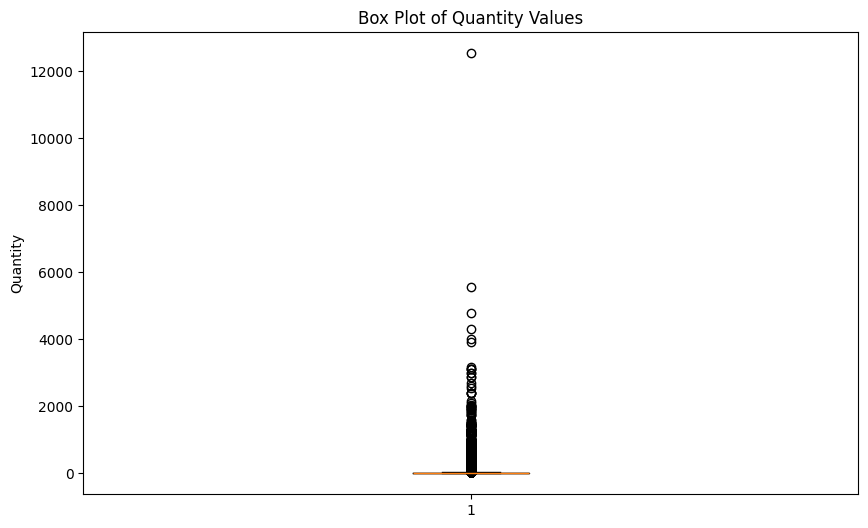

In [1364]:
# Visualize the distribution of Quantity with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(online_retail_raw_df['Quantity'])
plt.title('Box Plot of Quantity Values')
plt.ylabel('Quantity')
plt.show()

Investigate the only remaining outlier

In [1365]:
# Print records with Quantity more than 10000
outlier_quantities = online_retail_raw_df[(online_retail_raw_df['Quantity'] > 10000)]
print("Records with outlier Quantities (>10000):")
print(outlier_quantities)
print(f"\nNumber of records with outlier Quantities: {len(outlier_quantities)}")


Records with outlier Quantities (>10000):
       InvoiceNo StockCode                     Description  Quantity       InvoiceDate  UnitPrice CustomerID         Country
502122    578841     84826  ASSTD DESIGN 3D PAPER STICKERS     12540  11/25/2011 15:57        0.0      13256  United Kingdom

Number of records with outlier Quantities: 1


As this is a paper sticker prooduct, it is possible that a single sticker was bought in huge quantities. Hence, we will not drop this record.

#### <u>UnitPrice</u>

##### Statistical Summary:

In [1366]:
# Print statistical summary of the UnitPrice column
print(online_retail_raw_df['UnitPrice'].describe())

count    526052.000000
mean          3.871756
std          42.016640
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64


There are negative UnitPrice values

In [1367]:
# Count negative UnitPrices
negative_prices_count = (online_retail_raw_df['UnitPrice'] < 0).sum()

print(f"Number of records with negative UnitPrice: {negative_prices_count}")

# Show a sample of records with negative UnitPrice
negative_prices_sample = online_retail_raw_df[online_retail_raw_df['UnitPrice'] < 0].sample(min(5, negative_prices_count))

print("\nSample of records with negative UnitPrice:")
print(negative_prices_sample)


Number of records with negative UnitPrice: 2

Sample of records with negative UnitPrice:
       InvoiceNo StockCode      Description  Quantity      InvoiceDate  UnitPrice CustomerID         Country
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52  -11062.06        NaN  United Kingdom
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51  -11062.06        NaN  United Kingdom


As these are likely to be data entry errors, we will drop these records.

In [1368]:
print(f"Records before dropping negative UnitPrice: {len(online_retail_raw_df)}")
online_retail_raw_df = online_retail_raw_df[online_retail_raw_df['UnitPrice'] >= 0]
print(f"Records after dropping negative UnitPrice: {len(online_retail_raw_df)}")


Records before dropping negative UnitPrice: 526052
Records after dropping negative UnitPrice: 526050


##### Outliers Check:

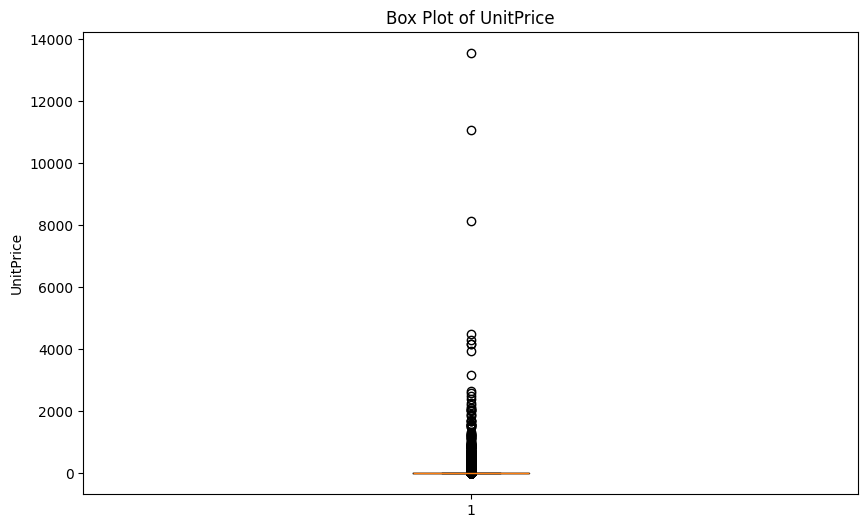

In [1369]:
# Visualize the distribution of UnitPrice with outliers

plt.figure(figsize=(10, 6))
plt.boxplot(online_retail_raw_df['UnitPrice'])
plt.title('Box Plot of UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

Investigating the outliers:

In [1370]:
# Select records where UnitPrice is over 5000
outlier_price = online_retail_raw_df[online_retail_raw_df['UnitPrice'] > 3000]

# Display the selected records
print("Records with UnitPrice over 5000:")
print(outlier_price)

# Print the number of such records
print(f"\nNumber of records with UnitPrice over 5000: {len(outlier_price)}")


Records with UnitPrice over 5000:
       InvoiceNo  StockCode      Description  Quantity       InvoiceDate  UnitPrice CustomerID         Country
15017     537632  AMAZONFEE       AMAZON FEE         1   12/7/2010 15:08   13541.33        NaN  United Kingdom
173382    551697       POST          POSTAGE         1    5/3/2011 13:46    8142.75      16029  United Kingdom
268028    560373          M           Manual         1   7/18/2011 12:30    4287.63        NaN  United Kingdom
297723    562955        DOT   DOTCOM POSTAGE         1   8/11/2011 10:14    4505.17        NaN  United Kingdom
299982   A563185          B  Adjust bad debt         1   8/12/2011 14:50   11062.06        NaN  United Kingdom
374542    569382          M           Manual         1   10/3/2011 16:44    3155.95      15502  United Kingdom
406406    571751          M           Manual         1  10/19/2011 11:18    3949.32      12744       Singapore
422351    573077          M           Manual         1  10/27/2011 14:13    41

Seems like these were Manual sales, hence we don't have enough evidence to consider them as outliers.

#### <u>InvoiceNo</u>

##### Check Standard Length of InvoiceNo:

In [1371]:
# Strip empty spaces from the InvoiceNo column
online_retail_raw_df['InvoiceNo'] = online_retail_raw_df['InvoiceNo'].str.strip()

# Check different lengths of InvoiceNo
invoice_lengths = online_retail_raw_df['InvoiceNo'].str.len()
length_counts = invoice_lengths.value_counts().sort_index()

print("InvoiceNo Length - RecordCounts")
for length, count in length_counts.items():
    print(f"{length} - {count}")


InvoiceNo Length - RecordCounts
6 - 526049
7 - 1


##### Check Standard Format of InvoiceNo: 

In [1372]:
# Check InvoiceNo for numeric and alphanumeric values
numeric_invoices = online_retail_raw_df['InvoiceNo'].str.isnumeric()
alphanumeric_invoices = ~numeric_invoices

numeric_count = numeric_invoices.sum()
alphanumeric_count = alphanumeric_invoices.sum()

print(f"Numeric Values: {numeric_count} ({numeric_count / len(online_retail_raw_df) * 100:.2f}%)")
print(f"Alphanumeric Values: {alphanumeric_count} ({alphanumeric_count / len(online_retail_raw_df) * 100:.2f}%)")


Numeric Values: 526049 (100.00%)
Alphanumeric Values: 1 (0.00%)


In [1373]:
# Select and display alphanumeric Invoice records
alphanumeric_invoices = online_retail_raw_df[online_retail_raw_df['InvoiceNo'].str.contains(r'[A-Za-z]', regex=True)]

print("Sample of alphanumeric Invoice records:", alphanumeric_invoices.head())


Sample of alphanumeric Invoice records:        InvoiceNo StockCode      Description  Quantity      InvoiceDate  UnitPrice CustomerID         Country
299982   A563185         B  Adjust bad debt         1  8/12/2011 14:50   11062.06        NaN  United Kingdom


Apparently this is an adjustment record. Hence we will drop this

In [1374]:
# Print record count before dropping
print(f"Record count before dropping: {len(online_retail_raw_df)}")

# Drop alphanumeric InvoiceNo records and update the dataframe
online_retail_raw_df = online_retail_raw_df[online_retail_raw_df['InvoiceNo'].str.isnumeric()]

# Print record count after dropping
print(f"Record count after dropping: {len(online_retail_raw_df)}")


Record count before dropping: 526050
Record count after dropping: 526049


#### <u>InvoiceDate</u>

##### Conversion of InvoiceDate Datatype:

In [1375]:
# Strip whitespace from the InvoiceDate column
online_retail_raw_df['InvoiceDate'] = online_retail_raw_df['InvoiceDate'].str.strip()

# Convert InvoiceDate to datetime
online_retail_raw_df['InvoiceDate'] = pd.to_datetime(online_retail_raw_df['InvoiceDate'])

# Print the changed data type
print(f"New data type of InvoiceDate: {online_retail_raw_df['InvoiceDate'].dtype}")

New data type of InvoiceDate: datetime64[ns]


##### Check InvoiceDate Range for anomality:

In [1376]:
# Check the minimum and maximum values in the InvoiceDate column
min_invoice_date = online_retail_raw_df['InvoiceDate'].min()
max_invoice_date = online_retail_raw_df['InvoiceDate'].max()

print(f"Minimum InvoiceDate: {min_invoice_date}")
print(f"Maximum InvoiceDate: {max_invoice_date}")

Minimum InvoiceDate: 2010-12-01 08:26:00
Maximum InvoiceDate: 2011-12-09 12:50:00


#### <u>Description</u>


##### Standardization of Description column:

In [1377]:
print(f"Number of unique Descriptions before standardization: {online_retail_raw_df['Description'].nunique()}")

# Standardize the Description column
online_retail_raw_df['Description'] = online_retail_raw_df['Description'].str.strip()  # Remove leading and trailing spaces
online_retail_raw_df['Description'] = online_retail_raw_df['Description'].str.replace(r'\s+', ' ', regex=True)  # Remove extra spaces between words
online_retail_raw_df['Description'] = online_retail_raw_df['Description'].str.upper()  # Capitalize the entire value
online_retail_raw_df['Description'] = online_retail_raw_df['Description'].str.rstrip('.')  # Remove any fullstops at the end of the Description


# Display some statistics about the Description column after standardization
print(f"Number of unique Descriptions after standardization: {online_retail_raw_df['Description'].nunique()}")


Number of unique Descriptions before standardization: 4075
Number of unique Descriptions after standardization: 4049


##### Imputation of the Null Descriptions:


(This section assumes that the Description column is the product description of the associated StockCode which is the predominant type of values in this column. However, there are instances where the value is not a product description but a description of the transaction.)

In [1378]:
# Select all unique StockCodes that have null value in Description
stock_codes_with_null_desc = online_retail_raw_df[online_retail_raw_df['Description'].isnull()]['StockCode'].unique()

print(f"Number of unique StockCodes with null Description: {len(stock_codes_with_null_desc)}")

# Count StockCodes that have only one non-null Description value and check for multiple descriptions
stock_codes_with_one_desc = []
stock_codes_with_multiple_desc = []

for stock_code in stock_codes_with_null_desc:
    non_null_desc = online_retail_raw_df[(online_retail_raw_df['StockCode'] == stock_code) & 
                                         (online_retail_raw_df['Description'].notnull())]['Description'].unique()
    
    if len(non_null_desc) == 1:
        stock_codes_with_one_desc.append(stock_code)
    elif len(non_null_desc) > 1:
        stock_codes_with_multiple_desc.append(stock_code)

# Print the counts
print(f"Number of StockCodes with only one non-null Description: {len(stock_codes_with_one_desc)} ({len(stock_codes_with_one_desc)/960:.1%})")
print(f"Number of StockCodes with multiple non-null Descriptions: {len(stock_codes_with_multiple_desc)} ({len(stock_codes_with_multiple_desc)/960:.1%})")


Number of unique StockCodes with null Description: 426
Number of StockCodes with only one non-null Description: 352 (36.7%)
Number of StockCodes with multiple non-null Descriptions: 58 (6.0%)


In [1379]:
# Create a dictionary mapping StockCodes to their single non-null Description
stock_code_to_desc = {}
for stock_code in stock_codes_with_one_desc:
    desc = online_retail_raw_df[(online_retail_raw_df['StockCode'] == stock_code) & 
                                (online_retail_raw_df['Description'].notnull())]['Description'].iloc[0]
    stock_code_to_desc[stock_code] = desc

# Fill null Descriptions for StockCodes with one non-null Description
mask = (online_retail_raw_df['StockCode'].isin(stock_codes_with_one_desc)) & (online_retail_raw_df['Description'].isnull())
online_retail_raw_df.loc[mask, 'Description'] = online_retail_raw_df.loc[mask, 'StockCode'].map(stock_code_to_desc)

# Print the number of unique StockCodes with null Description
unique_stock_codes_null_desc = online_retail_raw_df[online_retail_raw_df['Description'].isnull()]['StockCode'].nunique()
print(f"Number of unique StockCodes with null Description: {unique_stock_codes_null_desc}")

# Print the number of filled Descriptions
filled_count = mask.sum()
print(f"Number of Descriptions filled: {filled_count}")


Number of unique StockCodes with null Description: 74
Number of Descriptions filled: 464


##### Unique Descriptions for each StockCode:


StockCodes with multiple Descriptions

In [1380]:
stock_codes_multiple_desc = online_retail_raw_df.groupby('StockCode')['Description'].nunique().reset_index()
stock_codes_multiple_desc = stock_codes_multiple_desc[stock_codes_multiple_desc['Description'] > 1].sort_values('Description', ascending=False).rename(columns={'Description': 'UniqueDescCount'})
print("StockCodes with multiple Descriptions:\n", stock_codes_multiple_desc.head())
print(f"\nTotal number of StockCodes with multiple Descriptions: {len(stock_codes_multiple_desc)}")


StockCodes with multiple Descriptions:
      StockCode  UniqueDescCount
1946     23084                6
168      20713                5
2093     23236                4
2066     23209                4
417      21181                4

Total number of StockCodes with multiple Descriptions: 332


Standardizing the Descriptions for these 274 StockCodes

In [1381]:
# Create a dictionary mapping StockCodes to their most frequent Description
stock_code_to_mode_desc = online_retail_raw_df[online_retail_raw_df['StockCode'].isin(stock_codes_multiple_desc['StockCode'])].groupby('StockCode')['Description'].agg(lambda x: x.mode()[0]).to_dict()

# Update the Descriptions for StockCodes with multiple Descriptions
mask = online_retail_raw_df['StockCode'].isin(stock_codes_multiple_desc['StockCode'])
online_retail_raw_df.loc[mask, 'Description'] = online_retail_raw_df.loc[mask, 'StockCode'].map(stock_code_to_mode_desc)

# Verify the changes
updated_stock_codes = online_retail_raw_df.groupby('StockCode')['Description'].nunique()
print(f"Number of StockCodes with multiple Descriptions after update: {(updated_stock_codes > 1).sum()}")
print(f"Number of Descriptions standardized: {mask.sum()}")


Number of StockCodes with multiple Descriptions after update: 0
Number of Descriptions standardized: 67911


#### <u>StockCode</u>


##### StockCodes with overlapping Descriptions:

In [1382]:
# Descriptions with multiple StockCodes
desc_multiple_stockcodes = online_retail_raw_df.groupby('Description')['StockCode'].nunique().reset_index()
desc_multiple_stockcodes = desc_multiple_stockcodes[desc_multiple_stockcodes['StockCode'] > 1].sort_values('StockCode', ascending=False).rename(columns={'StockCode': 'UniqueStockCodeCount'})

print("Descriptions with multiple StockCodes:")
print(desc_multiple_stockcodes.head())
print(f"\nTotal number of Descriptions with multiple StockCodes: {len(desc_multiple_stockcodes)}")

Descriptions with multiple StockCodes:
                         Description  UniqueStockCodeCount
1929  METAL SIGN,CUPCAKE SINGLE HOOK                     6
2971   SET OF 4 FAIRY CAKE PLACEMATS                     4
802           COLUMBIAN CANDLE ROUND                     3
2830           SCOTTIE DOGS BABY BIB                     2
2763       ROSE DU SUD CUSHION COVER                     2

Total number of Descriptions with multiple StockCodes: 129


In [1383]:
description_to_check = "METAL SIGN,CUPCAKE SINGLE HOOK"
print(f"\nAll StockCodes for '{description_to_check}':")
print(online_retail_raw_df[online_retail_raw_df['Description'] == description_to_check]['StockCode'].unique())


All StockCodes for 'METAL SIGN,CUPCAKE SINGLE HOOK':
['82613B' '82613C' '82613A' '82613b' '82613c' '82613a']


In [1384]:
description_to_check = "SET OF 4 FAIRY CAKE PLACEMATS"
print(f"\nAll StockCodes for '{description_to_check}':")
print(online_retail_raw_df[online_retail_raw_df['Description'] == description_to_check]['StockCode'].unique())


All StockCodes for 'SET OF 4 FAIRY CAKE PLACEMATS':
['84509B' '84509G' '84509b' '84509g']


The incosistent capitalization of the StockCode is creating overlapping descriptions. As they all have same description, it's safe to assume StockCode is not case-sensitive.

In [1385]:
# Unique StockCode count before standardization
print(f"Number of unique StockCodes before standardization: {online_retail_raw_df['StockCode'].nunique()}")

# Strip whitespaces and capitalize all StockCodes
online_retail_raw_df['StockCode'] = online_retail_raw_df['StockCode'].str.strip().str.upper()

# Unique StockCode count after standardization
print(f"Number of unique StockCodes after standardization: {online_retail_raw_df['StockCode'].nunique()}")


Number of unique StockCodes before standardization: 3939
Number of unique StockCodes after standardization: 3827


Let's check the StockCodes with overlapping descriptions again.

In [1386]:
# Descriptions with multiple StockCodes
desc_multiple_stockcodes = online_retail_raw_df.groupby('Description')['StockCode'].nunique().reset_index()
desc_multiple_stockcodes = desc_multiple_stockcodes[desc_multiple_stockcodes['StockCode'] > 1].sort_values('StockCode', ascending=False).rename(columns={'StockCode': 'UniqueStockCodeCount'})

print("Descriptions with multiple StockCodes:")
print(desc_multiple_stockcodes.head())
print(f"\nTotal number of Descriptions with multiple StockCodes: {len(desc_multiple_stockcodes)}")

Descriptions with multiple StockCodes:
                         Description  UniqueStockCodeCount
802           COLUMBIAN CANDLE ROUND                     3
1929  METAL SIGN,CUPCAKE SINGLE HOOK                     3
276              BATHROOM METAL SIGN                     2
2358   PINK FAIRY CAKE CUSHION COVER                     2
3258   SQUARE CHERRY BLOSSOM CABINET                     2

Total number of Descriptions with multiple StockCodes: 26


In [1387]:
description_to_check = "BATHROOM METAL SIGN"
print(f"\nAll StockCodes for '{description_to_check}':")
print(online_retail_raw_df[online_retail_raw_df['Description'] == description_to_check]['StockCode'].unique())


All StockCodes for 'BATHROOM METAL SIGN':
['82580' '21171']


This overlap is probably for referring to the same product in different countries or a different variant.

#### <u>Country</u>

##### Values in Country Column:

In [1388]:


# Unique Country Values
unique_countries = online_retail_raw_df['Country'].unique()
print("Unique values in the Country column:", unique_countries)
print(f"\nNumber of unique countries: {len(unique_countries)}")


Unique values in the Country column: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Bahrain' 'Israel' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']

Number of unique countries: 38


Renaming and capitalizing the values:

In [1389]:
# List of country names to be renamed
country_replacements = {
    'EIRE': 'Ireland',
    'USA': 'United States',
    'RSA': 'South Africa'
}

#Replace the country names 
online_retail_raw_df['Country'] = online_retail_raw_df['Country'].replace(country_replacements)

# Capitalizing the country names
online_retail_raw_df['Country'] = online_retail_raw_df['Country'].str.upper()


print("Updated unique values in the Country column:")
print(online_retail_raw_df['Country'].unique())

Updated unique values in the Country column:
['UNITED KINGDOM' 'FRANCE' 'AUSTRALIA' 'NETHERLANDS' 'GERMANY' 'NORWAY'
 'IRELAND' 'SWITZERLAND' 'SPAIN' 'POLAND' 'PORTUGAL' 'ITALY' 'BELGIUM'
 'LITHUANIA' 'JAPAN' 'ICELAND' 'CHANNEL ISLANDS' 'DENMARK' 'CYPRUS'
 'SWEDEN' 'FINLAND' 'AUSTRIA' 'BAHRAIN' 'ISRAEL' 'GREECE' 'HONG KONG'
 'SINGAPORE' 'LEBANON' 'UNITED ARAB EMIRATES' 'SAUDI ARABIA'
 'CZECH REPUBLIC' 'CANADA' 'UNSPECIFIED' 'BRAZIL' 'UNITED STATES'
 'EUROPEAN COMMUNITY' 'MALTA' 'SOUTH AFRICA']


##### Check Country x InvoiceNo/CustomerID relationship:

In [1390]:
# Check for CustomerIDs with multiple associated Countries
customer_country_counts = online_retail_raw_df.groupby('CustomerID')['Country'].nunique()
multi_country_customers = customer_country_counts[customer_country_counts > 1]

print(f"Number of CustomerIDs with multiple associated Countries: {len(multi_country_customers)}")

Number of CustomerIDs with multiple associated Countries: 8


In [1391]:
# Check for InvoiceNo with multiple associated Countries
invoice_country_counts = online_retail_raw_df.groupby('InvoiceNo')['Country'].nunique()
multi_country_invoices = invoice_country_counts[invoice_country_counts > 1]

print(f"Number of InvoiceNo with multiple associated Countries: {len(multi_country_invoices)}")

Number of InvoiceNo with multiple associated Countries: 0


From the above checks it can be determined that a CustomerID can have multiple associated countries (They most likely ordered from multiple countries). But an InvoiceNo should only have one country.

### Imputing missing CustomerID values:

##### List of countries with null CustomerID values:

In [1392]:
# Get the list of unique countries and their counts where CustomerID is null
null_customer_countries = online_retail_raw_df[online_retail_raw_df['CustomerID'].isnull()]['Country'].value_counts()
print("Countries and Null CustomerID counts:", null_customer_countries)
print(f"\nTotal number of records with null CustomerID: {null_customer_countries.sum()}")


Countries and Null CustomerID counts: Country
UNITED KINGDOM    131913
IRELAND              655
HONG KONG            280
UNSPECIFIED          201
SWITZERLAND          117
FRANCE                66
ISRAEL                47
PORTUGAL              39
BAHRAIN                1
Name: count, dtype: int64

Total number of records with null CustomerID: 133319


##### Standard CustomerID Length & Format:

In [1393]:
# Check different lengths of CustomerIDs
customer_id_lengths = online_retail_raw_df['CustomerID'].dropna().astype(str).str.len().value_counts().sort_index()

print("Count of CustomerIDs by length:", customer_id_lengths)
print(f"\nTotal number of non-null CustomerIDs: {customer_id_lengths.sum()}")



Count of CustomerIDs by length: CustomerID
5    392730
Name: count, dtype: int64

Total number of non-null CustomerIDs: 392730


Standard CustomerID length is 5 characters.

##### Imputing dummy CustomerIDs:

For each unique country with null CustomerID values, we will assign a dummy CustomerID. The dummy CustomerID will be a 5-digit string starting from 00001. In the raw dataset, the CustomerID was a float, hence we can be certain that our dummy values starting with 0 will not overlap with the actual CustomerIDs.

In [1394]:
conditions = []
choices = []

# Initial dummy ID
start_dummy_id = 1

# Loop through the countries and create conditions and choices
for country in null_customer_countries.index:
    condition = (online_retail_raw_df['CustomerID'].isnull()) & (online_retail_raw_df['Country'] == country)
    conditions.append(condition)
    
    dummy_id = f"{start_dummy_id:05d}"  # Format as 5-digit string
    choices.append(dummy_id)
    
    start_dummy_id += 1 #Increment for next country

# Apply np.select to assign the dummy CustomerIDs
online_retail_raw_df['CustomerID'] = np.select(conditions, choices, default=online_retail_raw_df['CustomerID'])

# List the dummy CustomerIDs assigned to each country
print("Dummy CustomerIDs assigned:")
for country, dummy_id in zip(null_customer_countries.index, choices):
    print(f"{country}: {dummy_id}")

# Check the remaining null CustomerIDs
print(f"\nRemaining null CustomerIDs: {online_retail_raw_df['CustomerID'].isnull().sum()}")

Dummy CustomerIDs assigned:
UNITED KINGDOM: 00001
IRELAND: 00002
HONG KONG: 00003
UNSPECIFIED: 00004
SWITZERLAND: 00005
FRANCE: 00006
ISRAEL: 00007
PORTUGAL: 00008
BAHRAIN: 00009

Remaining null CustomerIDs: 0


### Adding the TotalPrice column:

In [1395]:
# Add TotalPrice (UnitPrice * Quantity) column
online_retail_raw_df['TotalPrice'] = online_retail_raw_df['UnitPrice'] * online_retail_raw_df['Quantity']

# Round TotalPrice to two decimal points
online_retail_raw_df['TotalPrice'] = online_retail_raw_df['TotalPrice'].round(2)

# Preview head after adding TotalPrice column
print(online_retail_raw_df.head())

  InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  TotalPrice
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55      17850  UNITED KINGDOM       15.30
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39      17850  UNITED KINGDOM       20.34
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75      17850  UNITED KINGDOM       22.00
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39      17850  UNITED KINGDOM       20.34
4    536365    84029E        RED WOOLLY HOTTIE WHITE HEART         6 2010-12-01 08:26:00       3.39      17850  UNITED KINGDOM       20.34


### Final Preview & Statistics of the Dataset:

In [1396]:
# Final Statistics
print('\n',summarize_df(online_retail_raw_df))

# Display statistical summary of quantitative columns
print("\nStatistical summary of quantitative columns:")
print(online_retail_raw_df.describe())

# Display the size of the dataset
print(f"\nDataset size: {online_retail_raw_df.shape[0]} rows x {online_retail_raw_df.shape[1]} columns")

# Final Preview
pd.set_option('display.width', 1000)
print(pd.concat([online_retail_raw_df.head(2), online_retail_raw_df.tail(2)]))


              Non-NullCount  NullCount  Null(%)  UniqueValues        DataType
InvoiceNo           526049          0      0.0         20723          object
StockCode           526049          0      0.0          3827          object
Description         526033         16      0.0          3787          object
Quantity            526049          0      0.0           391           int64
InvoiceDate         526049          0      0.0         19048  datetime64[ns]
UnitPrice           526049          0      0.0          1291         float64
CustomerID          526049          0      0.0          4347          object
Country             526049          0      0.0            38          object
TotalPrice          526049          0      0.0          4594         float64

Statistical summary of quantitative columns:
            Quantity                    InvoiceDate      UnitPrice     TotalPrice
count  526049.000000                         526049  526049.000000  526049.000000
mean       10.4359

As we can see after the data cleaning process, the dataset is now free of outliers and missing values. Also, the data types of the columns are appropriate for the values they contain. There's also a new column callled TotalPrice.

The final dataset has 526049 records which is 97.05% of the original 541909 records.

## Export the cleaned dataset:


In [1397]:
online_retail_raw_df.to_csv('OnlineRetail_Cleaned.csv', index=False)

Average Order Value (AOV) per Country:
             Country         AOV
           SINGAPORE 3039.898571
         NETHERLANDS 3004.698316
           AUSTRALIA 2429.014211
               JAPAN 1969.282632
             LEBANON 1693.880000
           HONG KONG 1407.545455
              BRAZIL 1143.600000
              SWEDEN 1065.773056
         SWITZERLAND 1056.807407
             DENMARK 1053.074444
              ISRAEL 1016.176250
              NORWAY 1004.595556
        SOUTH AFRICA 1002.310000
             IRELAND  983.126806
              GREECE  952.104000
              CYPRUS  843.928125
     CHANNEL ISLANDS  786.174615
       UNITED STATES  716.078000
               SPAIN  683.984000
UNITED ARAB EMIRATES  634.093333
             ICELAND  615.714286
              CANADA  611.063333
             AUSTRIA  599.922353
            PORTUGAL  580.742241
             FINLAND  549.904390
               MALTA  545.118000
              FRANCE  534.758597
             GERMANY  500.390372
    

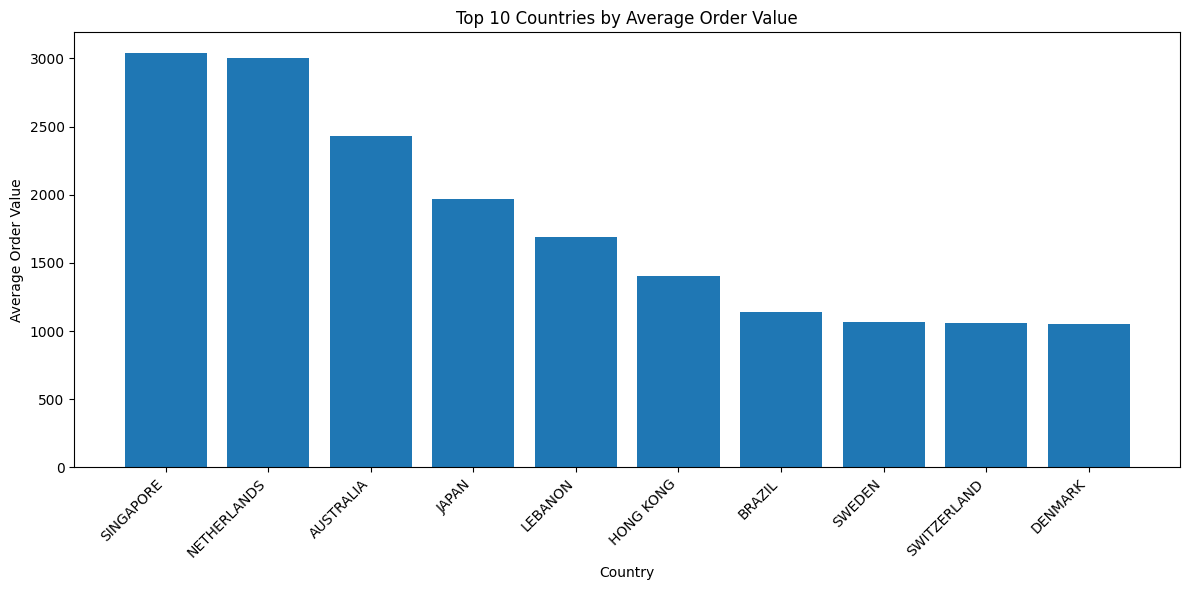

In [1398]:
# Calculate average order value per country
aov_by_country = online_retail_raw_df.groupby('Country').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

aov_by_country['AOV'] = aov_by_country['TotalPrice'] / aov_by_country['InvoiceNo']

# Sort by AOV in descending order
aov_by_country_sorted = aov_by_country.sort_values('AOV', ascending=False)

# Display the results
print("Average Order Value (AOV) per Country:")
print(aov_by_country_sorted[['Country', 'AOV']].to_string(index=False))

# Optionally, you can visualize this data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(aov_by_country_sorted['Country'][:10], aov_by_country_sorted['AOV'][:10])
plt.title('Top 10 Countries by Average Order Value')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 10 Countries by Customer Lifetime Value (CLTV):
    Country         CLTV
    IRELAND 88420.820000
NETHERLANDS 31716.260000
  SINGAPORE 21279.290000
  AUSTRALIA 15383.756667
     SWEDEN  4795.978750
      JAPAN  4677.046250
    ICELAND  4310.000000
     NORWAY  3616.544000
SWITZERLAND  2687.807143
    GERMANY  2432.748936

Average CLTV across all countries: 5858.12


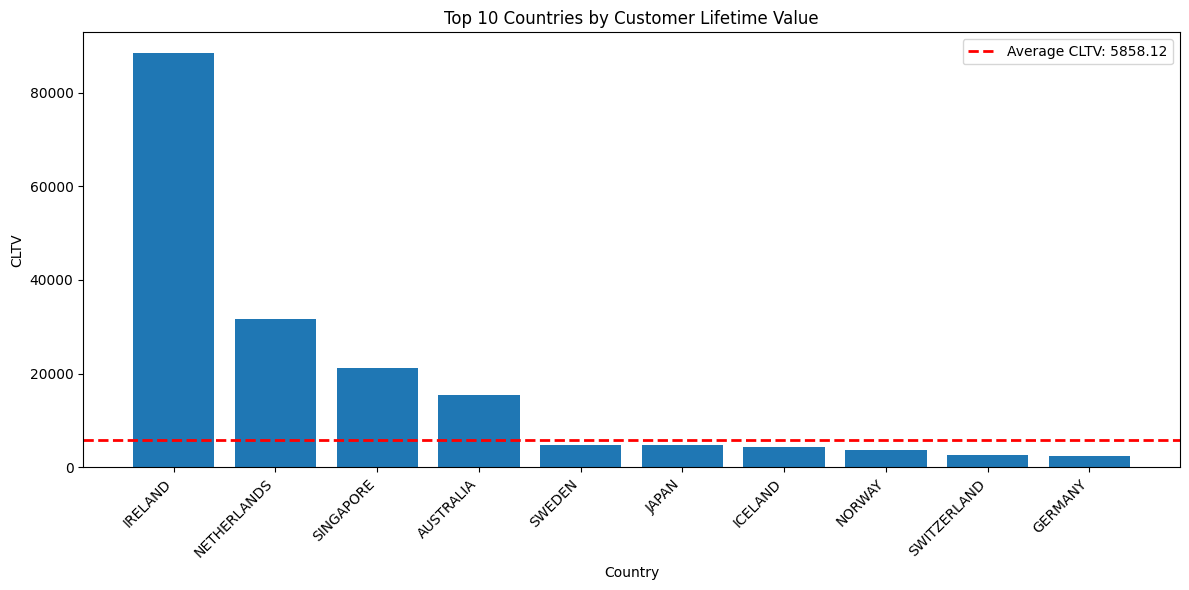

In [1400]:
# Calculate Customer Lifetime Value (CLTV) by Country

# Filter out customers with dummy IDs (starting with '0')
valid_customers = online_retail_raw_df[~online_retail_raw_df['CustomerID'].astype(str).str.startswith('0')]

# Calculate CLTV (total revenue per customer) by country
cltv_by_country = valid_customers.groupby(['Country', 'CustomerID'])['TotalPrice'].sum().reset_index()
cltv_by_country = cltv_by_country.groupby('Country')['TotalPrice'].mean().reset_index()
cltv_by_country.columns = ['Country', 'CLTV']

# Sort by CLTV in descending order
cltv_by_country_sorted = cltv_by_country.sort_values('CLTV', ascending=False)

# Display the top 10 countries by CLTV
print("Top 10 Countries by Customer Lifetime Value (CLTV):")
print(cltv_by_country_sorted.head(10).to_string(index=False))

# Calculate average CLTV across all countries
avg_cltv = cltv_by_country['CLTV'].mean()
print(f"\nAverage CLTV across all countries: {avg_cltv:.2f}")

# Visualize CLTV by country
plt.figure(figsize=(12, 6))
plt.bar(cltv_by_country_sorted['Country'][:10], cltv_by_country_sorted['CLTV'][:10])
plt.title('Top 10 Countries by Customer Lifetime Value')
plt.xlabel('Country')
plt.ylabel('CLTV')
plt.xticks(rotation=45, ha='right')
plt.axhline(avg_cltv, color='r', linestyle='dashed', linewidth=2, label=f'Average CLTV: {avg_cltv:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


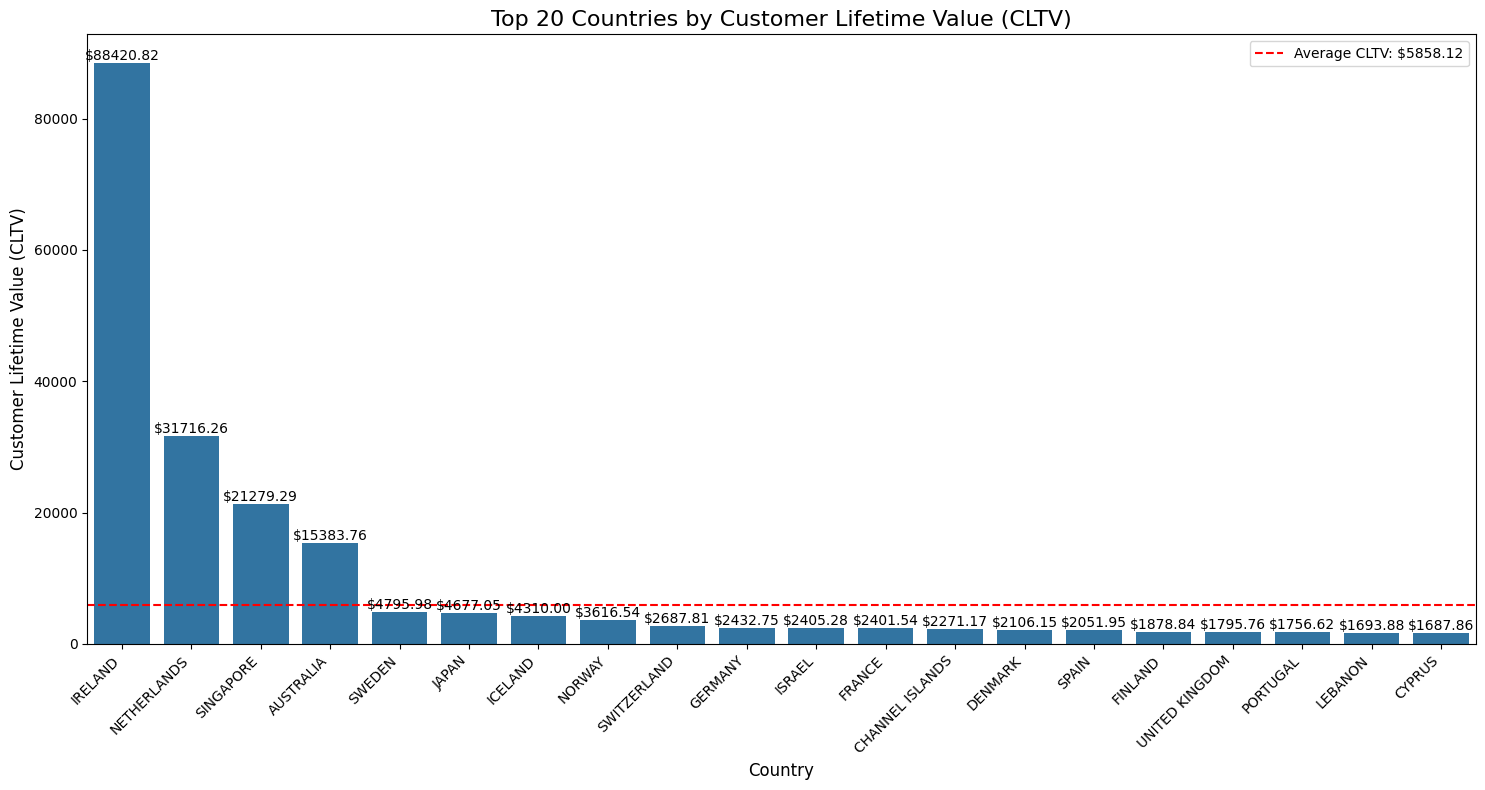

Summary Statistics for CLTV:
count       37.000000
mean      5858.123941
std      15270.616610
min        145.920000
25%       1143.600000
50%       1693.880000
75%       2432.748936
max      88420.820000
Name: CLTV, dtype: float64

Top 5 Countries by CLTV:
    Country         CLTV
    IRELAND 88420.820000
NETHERLANDS 31716.260000
  SINGAPORE 21279.290000
  AUSTRALIA 15383.756667
     SWEDEN  4795.978750

Bottom 5 Countries by CLTV:
       Country     CLTV
 UNITED STATES 895.0975
CZECH REPUBLIC 826.7400
   UNSPECIFIED 665.1925
       BAHRAIN 274.2000
  SAUDI ARABIA 145.9200


In [1405]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cltv_by_country_sorted is already calculated from previous steps

# Set up the plot
plt.figure(figsize=(15, 8))

# Create a bar plot for the top 20 countries by CLTV
sns.barplot(x='Country', y='CLTV', data=cltv_by_country_sorted.head(20))

# Customize the plot
plt.title('Top 20 Countries by Customer Lifetime Value (CLTV)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Customer Lifetime Value (CLTV)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(cltv_by_country_sorted['CLTV'].head(20)):
    plt.text(i, v, f'${v:.2f}', ha='center', va='bottom')

# Calculate and display the average CLTV
avg_cltv = cltv_by_country_sorted['CLTV'].mean()
plt.axhline(avg_cltv, color='r', linestyle='--', label=f'Average CLTV: ${avg_cltv:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for CLTV:")
print(cltv_by_country_sorted['CLTV'].describe())

# Print countries with highest and lowest CLTV
print("\nTop 5 Countries by CLTV:")
print(cltv_by_country_sorted.head().to_string(index=False))

print("\nBottom 5 Countries by CLTV:")
print(cltv_by_country_sorted.tail().to_string(index=False))

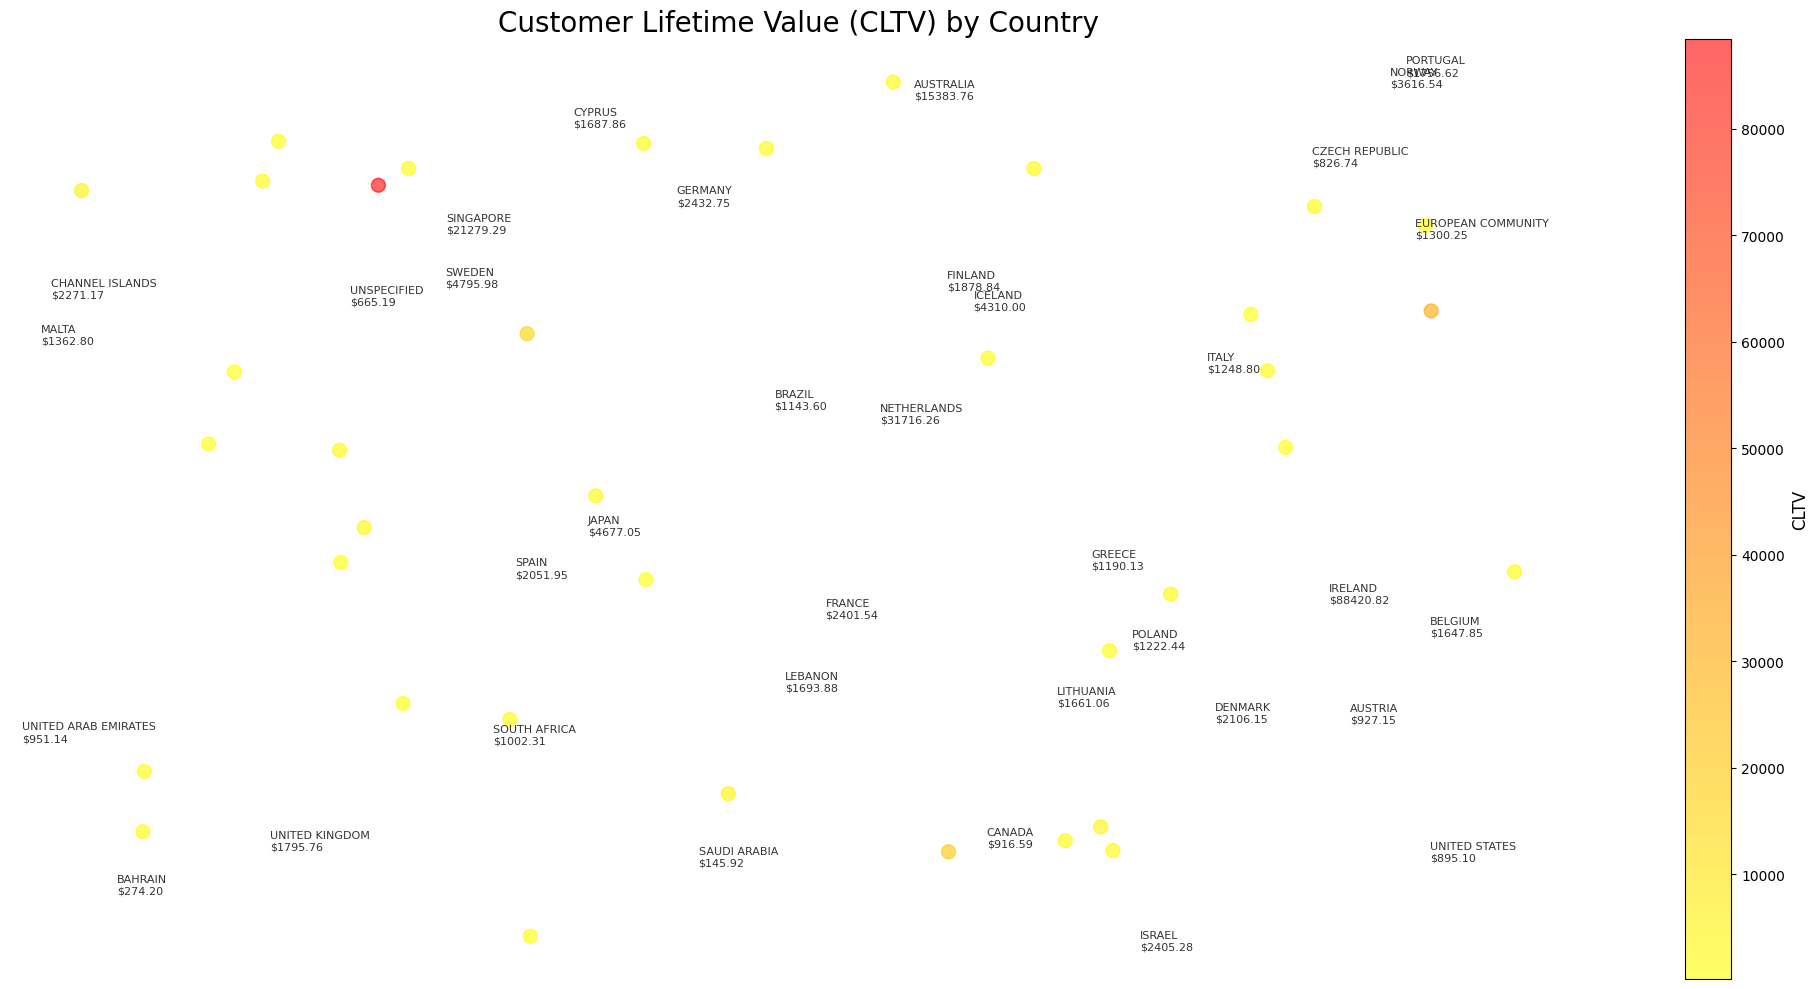

Summary Statistics for CLTV:
count       37.000000
mean      5858.123941
std      15270.616610
min        145.920000
25%       1143.600000
50%       1693.880000
75%       2432.748936
max      88420.820000
Name: CLTV, dtype: float64

Top 5 Countries by CLTV:
    Country         CLTV
    IRELAND 88420.820000
NETHERLANDS 31716.260000
  SINGAPORE 21279.290000
  AUSTRALIA 15383.756667
     SWEDEN  4795.978750

Bottom 5 Countries by CLTV:
       Country     CLTV
 UNITED STATES 895.0975
CZECH REPUBLIC 826.7400
   UNSPECIFIED 665.1925
       BAHRAIN 274.2000
  SAUDI ARABIA 145.9200


In [1408]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Assuming cltv_by_country_sorted is already calculated from previous steps

# Create a custom colormap from yellow to red
colors = ['#FFFF00', '#FF0000']  # Yellow to Red
n_bins = 100  # Number of color gradations
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Create the world map visualization
scatter = ax.scatter(
    x=np.random.rand(len(cltv_by_country_sorted)),  # Random x-coordinates
    y=np.random.rand(len(cltv_by_country_sorted)),  # Random y-coordinates
    c=cltv_by_country_sorted['CLTV'],
    cmap=cmap,
    s=100,  # Size of the dots
    alpha=0.6  # Transparency
)

# Customize the plot
ax.set_title('Customer Lifetime Value (CLTV) by Country', fontsize=20)
ax.axis('off')

# Add country labels
for i, row in cltv_by_country_sorted.iterrows():
    ax.annotate(f"{row['Country']}\n${row['CLTV']:.2f}", 
                (np.random.rand(), np.random.rand()),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLTV', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for CLTV:")
print(cltv_by_country_sorted['CLTV'].describe())

# Print countries with highest and lowest CLTV
print("\nTop 5 Countries by CLTV:")
print(cltv_by_country_sorted.head().to_string(index=False))

print("\nBottom 5 Countries by CLTV:")
print(cltv_by_country_sorted.tail().to_string(index=False))


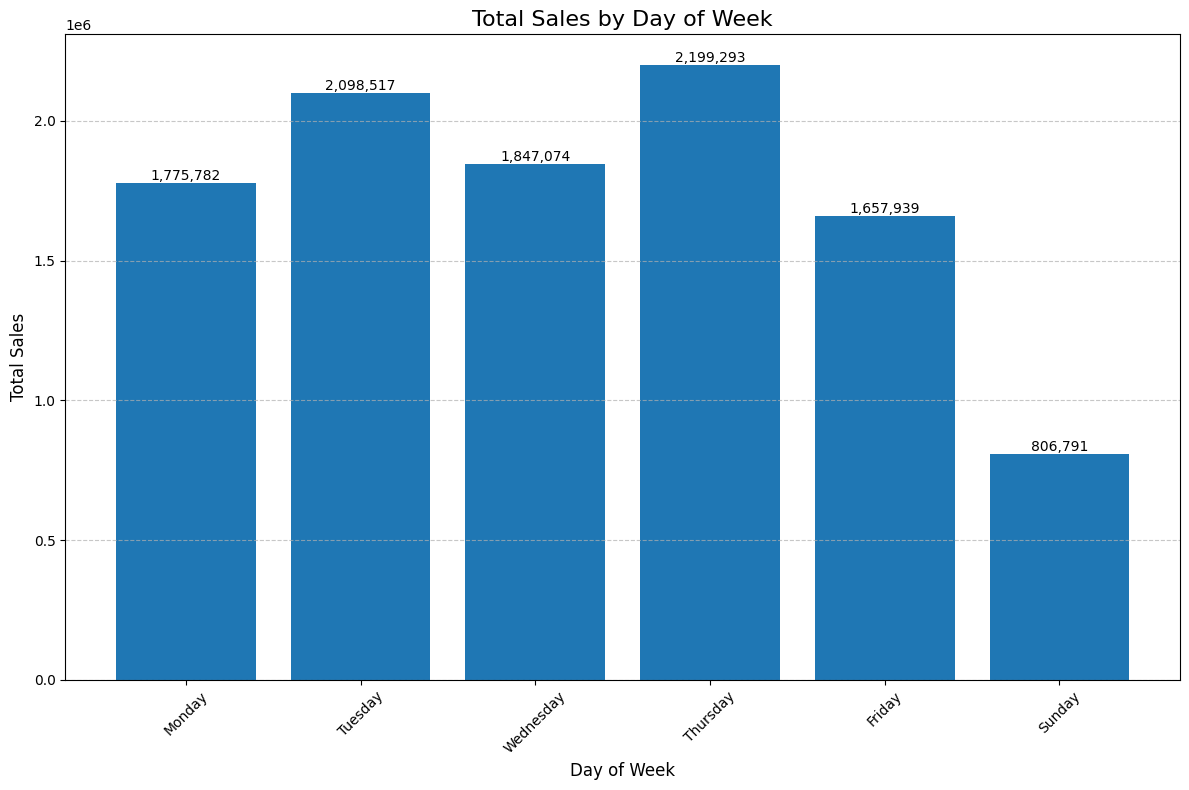


Summary of Total Sales by Day of Week:
DayOfWeek  TotalPrice
   Monday  1775782.07
  Tuesday  2098516.91
Wednesday  1847074.38
 Thursday  2199292.57
   Friday  1657938.83
   Sunday   806790.78

Day with highest sales: Thursday (2,199,292.57)
Day with lowest sales: Sunday (806,790.78)


In [1420]:
# Extract day of week from InvoiceDate
online_retail_raw_df['DayOfWeek'] = online_retail_raw_df['InvoiceDate'].dt.day_name()

# Group by DayOfWeek and calculate total sales
daily_sales = online_retail_raw_df.groupby('DayOfWeek')['TotalPrice'].sum().reset_index()

# Define custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales['DayOfWeek'] = pd.Categorical(daily_sales['DayOfWeek'], categories=day_order, ordered=True)

# Sort the dataframe by the custom day order
daily_sales = daily_sales.sort_values('DayOfWeek')

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(daily_sales['DayOfWeek'], daily_sales['TotalPrice'])
plt.title('Total Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(daily_sales['TotalPrice']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Total Sales by Day of Week:")
print(daily_sales.to_string(index=False))

# Identify the day with highest and lowest sales
max_day = daily_sales.loc[daily_sales['TotalPrice'].idxmax()]
min_day = daily_sales.loc[daily_sales['TotalPrice'].idxmin()]

print(f"\nDay with highest sales: {max_day['DayOfWeek']} ({max_day['TotalPrice']:,.2f})")
print(f"Day with lowest sales: {min_day['DayOfWeek']} ({min_day['TotalPrice']:,.2f})")
